<a href="https://colab.research.google.com/github/Hussien-Sayed/Earthquake-Modelling/blob/main/LGBM_Lag_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Load the data

In [ ]:
!pip install contextily

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Default Experiment config
n_clusters = 60
use_log = False          # only in Reg
th = 0.5                 # only in cls
undersample = False
OH_clusters = False

In [5]:
df = pd.read_csv("/content/drive/MyDrive/EM/updated_minable_SEOD.csv")

## Cluster The Data

In [6]:
def calculate_clustering(df,n_clusters=60, normalized=False,):
    """
    Function to calculate clustering of the dataframe based on latitude and longitude
    Args:
        df: Dataframe
        normalized: (Boolean). Whether to normalized data or not before the clustering.

    Returns:Dataframe with cluster_label as new column.

    """
    df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
    coords = df[['latitude', 'longitude']]
    if normalized:
        scaler = MinMaxScaler()
        coords = scaler.fit_transform(coords)
    kmeans = KMeans(n_clusters =n_clusters , init ='k-means++')
    kmeans.fit(coords) # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(coords)
    labels = kmeans.predict(coords) # Labels of each point
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    return df

In [7]:
df = calculate_clustering(df,n_clusters=n_clusters, normalized=False)

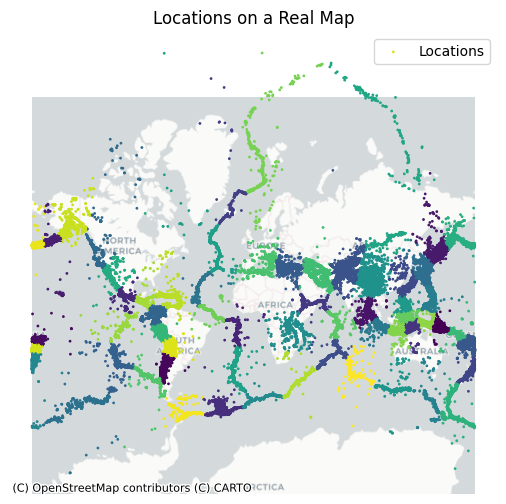

In [8]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip") #"https://data.buffalony.gov/resource/d6g9-xbgu.geojson"

gdf = gpd.sjoin(gdf, world, how="left", predicate="within")

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax,column='cluster_label', cmap='viridis', markersize=1, label="Locations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # You can change the basemap provider
ax.set_title("Locations on a Real Map")
ax.legend()
ax.set_axis_off()
plt.show()


## Complete the Data

In [9]:
#define day_frac
time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))
df["day_frac"] = (time_value.dt.hour * 3600 + time_value.dt.minute * 60 + time_value.dt.second)/ (24 * 60 * 60)


<ipython-input-9-2f802f072179>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))


In [10]:
# define a row for all clusters for all days
filled_data = df[['year','month','day']].copy()
filled_data.drop_duplicates(inplace=True)
filled_data_clusters = filled_data.loc[filled_data.index.repeat(n_clusters)].reset_index(drop=True)
filled_data_clusters["cluster_label"] = np.tile(np.arange(n_clusters), len(filled_data)).astype("int32")

#define cols to be merged with the filled_data_clusters
non_cluster_cols = df.columns.difference(['latitude', 'longitude', 'depth', 'mag','cluster_label',"time","day_frac"])

#,'ill_frac_interpolated','r/km_interpolated', 'dec_interpolated','ra/h_interpolated',
#'ra/°_interpolated', 'td_acc_interpolated',

#define cols to be aggregated
cluster_cols = df.columns.difference(non_cluster_cols).tolist() + ['year','month','day']
cluster_cols.remove("time")

filled_data_clusters = filled_data_clusters.merge(df[non_cluster_cols].drop_duplicates(),how ="left",on=['year','month','day'])
n_earthquakes = df[cluster_cols].groupby(['year','month','day','cluster_label']).day.count().rename("n_earthquakes")
agg_df_per_cluster = df[cluster_cols].groupby(['year','month','day','cluster_label']).mean()
agg_df_per_cluster = pd.concat((agg_df_per_cluster,n_earthquakes),axis=1).reset_index()
filled_data_clusters = filled_data_clusters.merge(agg_df_per_cluster,how ="left",on=['year','month','day','cluster_label'])

filled_data_clusters["mag"] = filled_data_clusters["mag"].fillna(0)
filled_data_clusters["n_earthquakes"] = filled_data_clusters["n_earthquakes"].fillna(0)
nan_cols = filled_data_clusters.columns[filled_data_clusters.isna().any(axis=0)]

filled_data_clusters[nan_cols] = filled_data_clusters[nan_cols].fillna(filled_data_clusters.groupby(['year','month','day'])[nan_cols].transform('mean'))

# inverse clusters to sample locations for generated data of non-existing Earthquakes
for cluster_ix in tqdm(filled_data_clusters.cluster_label.unique()):
    df_to_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] == 0)
    df_from_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] != 0)
    n_samples = sum(df_to_fill_ix)
    filled_data_clusters.loc[df_to_fill_ix, ["latitude","longitude"] ] = \
    filled_data_clusters.loc[df_from_fill_ix, ["latitude","longitude"] ].sample(n_samples,replace=True).values

#define random values for day_frac of non-existing Earthquakes
filled_data_clusters.loc[filled_data_clusters.mag==0,"day_frac"] = np.random.rand((filled_data_clusters.mag==0).sum())

#define intrp values
delta = filled_data_clusters[['ill_frac_1','r/km_1','dec_1','ra/h_1','ra/°_1','td_acc_1']].values - filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values
filled_data_clusters[['ill_frac_interpolated','r/km_interpolated','dec_interpolated','ra/h_interpolated','ra/°_interpolated','td_acc_interpolated']] = filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values + delta * filled_data_clusters.day_frac.values.reshape(-1,1)


#remove range(4.5-4.8) from being considered as earthquake
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"n_earthquakes"] = 0
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"mag"] = 0

#fill 0 values eathquake magnitude with a distribution for un noticed earthquake magnitudes
#ix1 = np.arange(0,1.7,0.00671)
#ix2 = np.arange(1.7,4.5,0.00671)

#val1 = [3.5]*len(ix1)
#val2 = np.linspace(3.5,1,len(ix2))
#ix = np.hstack((ix1,ix2))
#val = np.hstack((val1,val2))
#val = np.power(10,val)

#gen_dist = []
#for i,v in zip(ix,val):
#    gen_dist.extend([i]*int(v))
#np.random.shuffle(gen_dist)

#filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = gen_dist[:(filled_data_clusters.mag==0).sum()]
filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = 2.4  #median value

100%|██████████| 60/60 [00:05<00:00, 11.61it/s]


Text(0, 0.5, 'count')

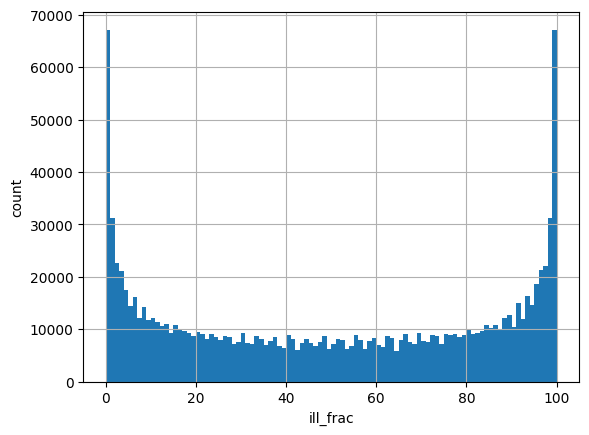

In [11]:
filled_data_clusters.ill_frac.hist(bins=100)
plt.xlabel("ill_frac")
plt.ylabel("count")

## Feature Engineering

In [12]:
# remove useless columns
filled_data_clusters.drop(['dec', 'dec_1',
 'ill_frac', 'ill_frac_1',
 'r/km', 'r/km_1',
 'ra/h', 'ra/h_1',
 'ra/°','ra/°_1',
 'td_acc', 'td_acc_1',
 ],axis=1,inplace=True)

In [13]:
# Normalize
cols_to_normalize = ['acum_day','ill_frac_interpolated', 'r/km_interpolated', 'dec_interpolated',
       'ra/h_interpolated', 'ra/°_interpolated', 'td_acc_interpolated']

scaler = MinMaxScaler()
filled_data_clusters[cols_to_normalize] = scaler.fit_transform(filled_data_clusters[cols_to_normalize])

In [14]:
#OneHot encoding
if OH_clusters:
    one_hot_df = pd.get_dummies(filled_data_clusters.cluster_label)
    one_hot_df.columns = [f"cluster_{i}" for i in range(0,one_hot_df.shape[1])]
    filled_data_clusters = pd.concat((filled_data_clusters,one_hot_df),axis=1)


In [15]:
# lag
filled_data_clusters.sort_values(['year','month','day','cluster_label'],inplace=True)

n_lags = 60
for lag in range(1,n_lags+1):
    filled_data_clusters[f"mag_lag_{lag}"] = filled_data_clusters.mag.shift(lag*n_clusters)



## Classification Model

In [26]:

exclude_from_train = ['depth', 'mag', 'n_earthquakes']
X = filled_data_clusters[filled_data_clusters.columns.difference(exclude_from_train)].copy()
y = filled_data_clusters['mag'].copy()
y = (y>=4.8).astype("int")

X_test  = X[X.year>=2015].copy()
y_test = y[X.year>=2015].copy()

X_tv = X[X.year<2015].copy()
y_tv = y[X.year<2015].copy()


if undersample:
    ix_org = y_tv==1
    ix_gen = y_tv==0

    n_samples = sum(ix_org)
    ix_gen_sampled = y_tv[ix_gen].sample(n_samples).index
    ix_org = y_tv[ix_org].index

    full_ix = ix_gen_sampled.append(ix_org)

    X_tv = X_tv.loc[full_ix]
    y_tv = y_tv.loc[full_ix]
    X_tv = X_tv.sample(frac=1)
    y_tv = y_tv.sample(frac=1)

#Dummy score
print("dummy_score")
dummy_score = accuracy_score(y_test, np.repeat(np.median(y_test),len(y_test)))
print(dummy_score)
X_train, X_val, y_train, y_val = train_test_split(X_tv,y_tv, test_size=0.2, random_state=42)

params = {
          'objective': 'binary',  #'multiclass',
          'metric': 'binary_logloss', #'multi_logloss',
          'verbose': 0,

          'learning_rate': 0.020630777946613298,
          'max_depth': 5,
          'num_leaves': 115,
          'lambda_l1': 2.8668347743381846,
          'lambda_l2': 6.947895600053129,
          'boosting_type': 'gbdt'
          }



lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val =  lgb.Dataset(X_val, label=y_val, reference=lgb_train)


model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=10000,
    callbacks=[lgb.early_stopping(stopping_rounds=100)],
)

#determine best th from valid set

y_pred_proba = model.predict(X_val)
thresholds = np.linspace(0, 1, 100)  # Vary threshold from 0 to 1
accuracies = []

for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)  # Apply threshold
    accuracies.append(accuracy_score(y_val, y_pred))

# Find the best threshold
best_threshold = thresholds[np.argmax(accuracies)]



#apply test on testset

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= best_threshold).astype(int)  # Apply threshold
best_accuracy = accuracy_score(y_test, y_pred)

print("best_accuracy: ",best_accuracy,"best_threshold: ",best_threshold)


dummy_score
0.903886478669559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

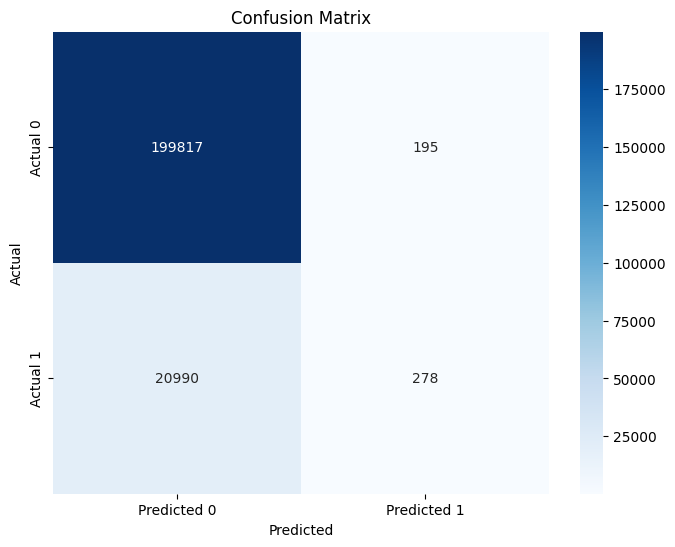

,Feature,Importance
7,longitude,2720
3,day_frac,2581
6,latitude,2415
1,cluster_label,1908
73,year,1776
...,...,...
17,mag_lag_18,174
40,mag_lag_39,169
29,mag_lag_29,168
68,month,22


In [28]:
y_pred = y_pred_proba > best_threshold

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / np.repeat([[(y_test==0).sum(),(y_test==1).sum()]],2,axis=0).T
FP,TP = cm_norm[:,1]


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


feature_importances =  model.feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df


In [29]:
from statsmodels.stats.contingency_tables import mcnemar

# Sample binary classification results (1: Correct, 0: Incorrect)
# True labels
y_pred_baseline = np.repeat(0,len(y_test))

# (McNemar's Matrix)
b = sum((y_pred_baseline == y_test) & (y_pred.astype("int") != y_test))  # Baseline correct, New incorrect
c = sum((y_pred_baseline != y_test) & (y_pred.astype("int") == y_test))  # Baseline incorrect, New correct

contingency_table = np.array([[0, b], [c, 0]])
print("Contingency Table:\n", pd.DataFrame(contingency_table, columns=["New Wrong", "New Correct"], index=["Baseline Wrong", "Baseline Correct"]))

# Perform McNemar's test
result = mcnemar(contingency_table, exact=True)  # Use 'exact=True' for small samples

print(f"\nMcNemar's Test Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

# Interpretation
alpha = 0.05  # Significance level
if result.pvalue < alpha:
    print("Reject the null hypothesis: The new model has significantly different performance.")
else:
    print("Fail to reject the null hypothesis: No significant performance difference between models.")


Contingency Table:
                   New Wrong  New Correct
Baseline Wrong            0          195
Baseline Correct        278            0

McNemar's Test Statistic: 195.0
P-value: 0.00015730825518159256
Reject the null hypothesis: The new model has significantly different performance.


In [31]:
from statsmodels.stats.contingency_tables import mcnemar

# Sample binary classification results (1: Correct, 0: Incorrect)
# True labels
y_pred_baseline = np.repeat(0,len(y_test))

# (McNemar's Matrix)
a = sum((y_pred_baseline == y_test) & (y_pred.astype("int") == y_test))  # Both correct
b = sum((y_pred_baseline == y_test) & (y_pred.astype("int") != y_test))  # Baseline correct, New incorrect
c = sum((y_pred_baseline != y_test) & (y_pred.astype("int") == y_test))  # Baseline incorrect, New correct
d = sum((y_pred_baseline != y_test) & (y_pred.astype("int") != y_test))  # Both incorrect

contingency_table = np.array([[a, b], [c, d]])
print("Contingency Table:\n", pd.DataFrame(contingency_table, columns=["New Wrong", "New Correct"], index=["Baseline Wrong", "Baseline Correct"]))

# Perform McNemar's test
result = mcnemar(contingency_table, exact=True)  # Use 'exact=True' for small samples

print(f"\nMcNemar's Test Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

# Interpretation
alpha = 0.05  # Significance level
if result.pvalue < alpha:
    print("Reject the null hypothesis: The new model has significantly different performance.")
else:
    print("Fail to reject the null hypothesis: No significant performance difference between models.")


Contingency Table:
                   New Wrong  New Correct
Baseline Wrong       199817          195
Baseline Correct        278        20990

McNemar's Test Statistic: 195.0
P-value: 0.00015730825518159256
Reject the null hypothesis: The new model has significantly different performance.
